In [ ]:
cat /etc/*release* | head -n5

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"
NAME="Ubuntu"


In [ ]:
import os
import re
import json 
from  pprint import pprint
from matplotlib import pyplot as plt

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/YOLOv4'
VID_DIR = '/content/drive/MyDrive/YOLOv4/wideo'
CLASSES = ('Person', 'person')
CODECS = ('h264', 'h265')
BITRATES = ['300k', '400k', '500k', '600k', '700k', '800k', '900k', '1000k', '1500k', '2000k', '3000k']

In [ ]:
def _setup():
    %cd /content/
    !rm -rf /content/darknet
    !rm -rf sample_data
    !git clone https://github.com/AlexeyAB/darknet
    %cd darknet
    !cp -v {PROJECT_PATH}/detektor/custom.cfg cfg/
    !cp -v {PROJECT_PATH}/detektor/custom.data data/
    !cp -v {PROJECT_PATH}/detektor/custom.names data/
    !cp -v {PROJECT_PATH}/detektor/wagi/*_last.weights .
    !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
    !sed -i 's/GPU=0/GPU=1/' Makefile
    !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
    !sed -i 's/batch=64/batch=1/' cfg/custom.cfg
    !sed -i 's/subdivisions=16/subdivisions=1/' cfg/custom.cfg
    !make
    %cd /content/


def _detect(weights_file, cfg_file, data_file, vid_filename):
    print(f'Detecting {vid_filename}...')
    log_filename = vid_filename.split('.')[0] + '.log'
    # if not os.path.exists(f'{VID_DIR}/logi/{log_filename}'):
    output = !./darknet detector demo $data_file $cfg_file \
    $weights_file -dont_show $VID_DIR/skompresowane/$vid_filename -i 0 \
    -out_filename $VID_DIR/wyniki/$vid_filename
    with open(os.path.join(VID_DIR, 'logi', log_filename), 'w') as f:
        f.writelines('\n'.join(output))
    return log_filename


def _get_confidence(log_filename):
    print(f'Calc confidence for {log_filename}...')
    tot_score, tot_detections = 0, 0
    with open(os.path.join(VID_DIR, 'logi', log_filename), 'r') as f:
        for l in f.readlines():
            for c in CLASSES:
                if c in l:
                    confidence = re.findall(pattern=r'\d*%', string=l)[0]
                    tot_score += int(confidence[:-1])
                    tot_detections += 1
    return {
        'filename': log_filename.split('.')[0] + '.mp4', 
        'confidence': tot_score / tot_detections if tot_detections != 0 \
        else 0
    }


def _compare_confidence(data_custom, data_coco):
    fig, (ax_custom, ax_coco) = plt.subplots(nrows=1, ncols=2, figsize=[12.8, 4.8])
    x_axis_values = [i[:-1] for i in BITRATES]
    for i, (ax, data) in enumerate(zip((ax_custom, ax_coco), (data_custom, data_coco))):
        title = 'a)' if i == 0 else 'b)'
        ax.set_ylabel('Confidence [%]')
        ax.set_xlabel('Bitrate [kbps]')
        ax.set_title(title)
        for tick in ax.get_xticklabels():
            tick.set_rotation(60)
        for ref_video_file in data:
            for codec in data[ref_video_file]:
                y_values = list(i['confidence']\
                                for i in data[ref_video_file][codec])
                ax.plot(x_axis_values, y_values, \
                        label=codec + ' ' + ref_video_file, marker='o')
                ax.legend(loc=4, fontsize=10)
    plt.savefig('detection-confidence')
    plt.show()


def main(weights_file, cfg_file, data_file, *ref_vids):
    _setup()
    %cd /content/darknet
    results = {}
    for ref_vid in ref_vids:
        ref_vid = 'beauty' if 'beauty' in ref_vid else 'readysetgo'
        results[ref_vid] = {}
        for codec in CODECS:
            results[ref_vid][codec] = []
            input_files = [f for f in os.listdir(f'{VID_DIR}/skompresowane')\
                            if codec in f and ref_vid in f]
            for f in input_files:
                results[ref_vid][codec].\
                append(_get_confidence(_detect(weights_file, cfg_file, data_file, f)))
    _compare_confidence(results)
    %cd /content/
    return results

# **Weryfikacja używanego układu GPU**

In [ ]:
!nvidia-smi

Wed Dec  8 09:36:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


# **Detekcja wideo**

In [ ]:
main(
    f'{PROJECT_PATH}/detektor/pre-trained/yolov4.weights',
    f'{PROJECT_PATH}/detektor/pre-trained/yolov4.cfg',
    'cfg/coco.data',
    '/content/drive/MyDrive/YOLOv4/wideo/referencyjne/beauty_1920x1080_120fps_20s.yuv', 
    '/content/drive/MyDrive/YOLOv4/wideo/referencyjne/readysetgo_1920x1080_120fps_20s.yuv'
)

In [ ]:
#  Zwrócone dane dla modelu COCO i custom
results_custom = {'beauty': {'h264': [{'confidence': 90.28621553884712,
    'filename': 'beauty_1920x1080_120fps_20s_h264_300k.mp4'},
   {'confidence': 97.65807560137458,
    'filename': 'beauty_1920x1080_120fps_20s_h264_400k.mp4'},
   {'confidence': 98.31996587030717,
    'filename': 'beauty_1920x1080_120fps_20s_h264_500k.mp4'},
   {'confidence': 98.30127118644067,
    'filename': 'beauty_1920x1080_120fps_20s_h264_600k.mp4'},
   {'confidence': 97.54126518642647,
    'filename': 'beauty_1920x1080_120fps_20s_h264_700k.mp4'},
   {'confidence': 98.1008753647353,
    'filename': 'beauty_1920x1080_120fps_20s_h264_800k.mp4'},
   {'confidence': 98.54267782426778,
    'filename': 'beauty_1920x1080_120fps_20s_h264_900k.mp4'},
   {'confidence': 97.56550308008214,
    'filename': 'beauty_1920x1080_120fps_20s_h264_1000k.mp4'},
   {'confidence': 94.03391107761868,
    'filename': 'beauty_1920x1080_120fps_20s_h264_1500k.mp4'},
   {'confidence': 93.63112927191679,
    'filename': 'beauty_1920x1080_120fps_20s_h264_2000k.mp4'},
   {'confidence': 91.95652173913044,
    'filename': 'beauty_1920x1080_120fps_20s_h264_3000k.mp4'}],
  'h265': [{'confidence': 82.19119608714985,
    'filename': 'beauty_1920x1080_120fps_20s_h265_300k.mp4'},
   {'confidence': 96.98305768455022,
    'filename': 'beauty_1920x1080_120fps_20s_h265_400k.mp4'},
   {'confidence': 97.4045584045584,
    'filename': 'beauty_1920x1080_120fps_20s_h265_500k.mp4'},
   {'confidence': 95.83313609467456,
    'filename': 'beauty_1920x1080_120fps_20s_h265_600k.mp4'},
   {'confidence': 94.97107597377556,
    'filename': 'beauty_1920x1080_120fps_20s_h265_700k.mp4'},
   {'confidence': 93.82722513089006,
    'filename': 'beauty_1920x1080_120fps_20s_h265_800k.mp4'},
   {'confidence': 91.83876683203403,
    'filename': 'beauty_1920x1080_120fps_20s_h265_900k.mp4'},
   {'confidence': 92.67150108774474,
    'filename': 'beauty_1920x1080_120fps_20s_h265_1000k.mp4'},
   {'confidence': 89.74503868146653,
    'filename': 'beauty_1920x1080_120fps_20s_h265_1500k.mp4'},
   {'confidence': 91.03776853776854,
    'filename': 'beauty_1920x1080_120fps_20s_h265_2000k.mp4'},
   {'confidence': 91.20707596253902,
    'filename': 'beauty_1920x1080_120fps_20s_h265_3000k.mp4'}]},
 'readysetgo': {'h264': [{'confidence': 43.68421052631579,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_300k.mp4'},
   {'confidence': 51.474654377880185,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_400k.mp4'},
   {'confidence': 58.997869101978694,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_500k.mp4'},
   {'confidence': 60.514534377719755,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_600k.mp4'},
   {'confidence': 65.24651162790698,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_700k.mp4'},
   {'confidence': 70.56311862342014,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_800k.mp4'},
   {'confidence': 75.52344213649852,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_900k.mp4'},
   {'confidence': 78.83143200240168,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_1000k.mp4'},
   {'confidence': 81.45155009734911,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_1500k.mp4'},
   {'confidence': 82.63501438739966,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_2000k.mp4'},
   {'confidence': 84.0721276916127,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_3000k.mp4'}],
  'h265': [{'confidence': 64.0114563106796,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_300k.mp4'},
   {'confidence': 64.01864439697029,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_400k.mp4'},
   {'confidence': 63.26695683714182,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_500k.mp4'},
   {'confidence': 74.60412692907924,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_600k.mp4'},
   {'confidence': 79.06515223221328,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_700k.mp4'},
   {'confidence': 81.45032380350655,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_800k.mp4'},
   {'confidence': 82.72773056342461,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_900k.mp4'},
   {'confidence': 82.89965774735532,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_1000k.mp4'},
   {'confidence': 84.07981077369143,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_1500k.mp4'},
   {'confidence': 84.02581232918311,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_2000k.mp4'},
   {'confidence': 84.10871195081721,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_3000k.mp4'}]}}


results_COCO = {'beauty': {'h264': [
   {'confidence': 49.35057471264368,
    'filename': 'beauty_1920x1080_120fps_20s_h264_300k.mp4'},
   {'confidence': 78.33613817537643,
    'filename': 'beauty_1920x1080_120fps_20s_h264_400k.mp4'},
   {'confidence': 81.8966108966109,
    'filename': 'beauty_1920x1080_120fps_20s_h264_500k.mp4'},
   {'confidence': 82.90808979246083,
    'filename': 'beauty_1920x1080_120fps_20s_h264_600k.mp4'},
   {'confidence': 84.0135593220339,
    'filename': 'beauty_1920x1080_120fps_20s_h264_700k.mp4'},
   {'confidence': 83.07624262847514,
    'filename': 'beauty_1920x1080_120fps_20s_h264_800k.mp4'},
    {'confidence': 83.44594026083298,
    'filename': 'beauty_1920x1080_120fps_20s_h264_900k.mp4'},
   {'confidence': 83.89663865546218,
    'filename': 'beauty_1920x1080_120fps_20s_h264_1000k.mp4'},
   {'confidence': 83.04927536231884,
    'filename': 'beauty_1920x1080_120fps_20s_h264_1500k.mp4'},
   {'confidence': 84.24190871369295,
    'filename': 'beauty_1920x1080_120fps_20s_h264_2000k.mp4'},
   {'confidence': 84.34124011652102,
    'filename': 'beauty_1920x1080_120fps_20s_h264_3000k.mp4'}],
  'h265': [{'confidence': 50.06073082861554,
    'filename': 'beauty_1920x1080_120fps_20s_h265_300k.mp4'},
   {'confidence': 81.16570723684211,
    'filename': 'beauty_1920x1080_120fps_20s_h265_400k.mp4'},
   {'confidence': 84.28854898718478,
    'filename': 'beauty_1920x1080_120fps_20s_h265_500k.mp4'},
   {'confidence': 84.46936223426428,
    'filename': 'beauty_1920x1080_120fps_20s_h265_600k.mp4'},
   {'confidence': 84.5118898623279,
    'filename': 'beauty_1920x1080_120fps_20s_h265_700k.mp4'},
   {'confidence': 85.37979966611019,
    'filename': 'beauty_1920x1080_120fps_20s_h265_800k.mp4'},
   {'confidence': 83.59958762886598,
    'filename': 'beauty_1920x1080_120fps_20s_h265_900k.mp4'},
    {'confidence': 83.04705400981997,
    'filename': 'beauty_1920x1080_120fps_20s_h265_1000k.mp4'},
   {'confidence': 84.31788079470199,
    'filename': 'beauty_1920x1080_120fps_20s_h265_1500k.mp4'},
    {'confidence': 84.41867219917012,
    'filename': 'beauty_1920x1080_120fps_20s_h265_2000k.mp4'},
   {'confidence': 84.80992080033347,
    'filename': 'beauty_1920x1080_120fps_20s_h265_3000k.mp4'}]},
 'readysetgo': {'h264': [
   {'confidence': 0,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_300k.mp4'},
   {'confidence': 28.8,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_400k.mp4'},
   {'confidence': 39.721194879089616,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_500k.mp4'},
    {'confidence': 43.49874623871615,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_600k.mp4'},
     {'confidence': 49.480710741155754,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_700k.mp4'},
    {'confidence': 54.75484435554444,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_800k.mp4'},
    {'confidence': 59.94741044946384,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_900k.mp4'},
   {'confidence': 62.49277654750606,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_1000k.mp4'},
   {'confidence': 68.56321050568404,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_1500k.mp4'},
    {'confidence': 70.398075998076,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_2000k.mp4'},
   {'confidence': 71.90660528046604,
    'filename': 'readysetgo_1920x1080_120fps_20s_h264_3000k.mp4'}],
  'h265': [
       {'confidence': 44.78083588175331,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_300k.mp4'},
   {'confidence': 44.734112862226745,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_400k.mp4'},
       {'confidence': 47.22459016393443,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_500k.mp4'},
    {'confidence': 61.62959457327654,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_600k.mp4'},
       {'confidence': 62.17403183654075,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_700k.mp4'},
   {'confidence': 64.2514014661492,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_800k.mp4'},
   {'confidence': 67.8306234521374,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_900k.mp4'},
   {'confidence': 67.82444490558207,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_1000k.mp4'},
       {'confidence': 68.82631077216396,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_1500k.mp4'},
       {'confidence': 70.45503048780488,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_2000k.mp4'},
   {'confidence': 71.21460800902425,
    'filename': 'readysetgo_1920x1080_120fps_20s_h265_3000k.mp4'}]}}

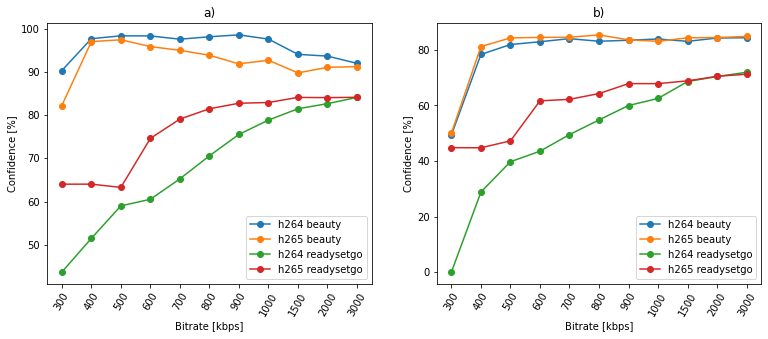

In [ ]:
_compare_confidence(results_custom, results_COCO)